<a href="https://colab.research.google.com/github/FaizanShaikh01-rgb/TSAF-forecasting-assignment/blob/main/TSAF_Assignment_Stock_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis & Forecasting Assignment
Using historical stock price data from Yahoo Finance.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import datetime
sns.set(style="whitegrid")


/tmp/ipython-input-2-1908849905.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


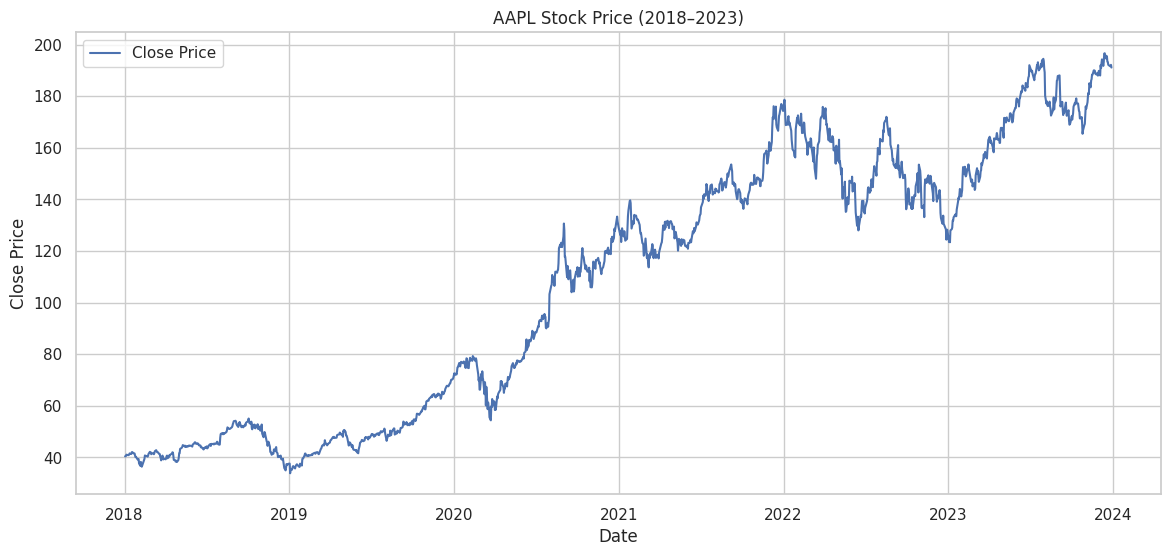

In [2]:
# Download historical stock data (5 years)
ticker = 'AAPL'  # Change to your desired stock symbol
df = yf.download(ticker, start="2018-01-01", end="2023-12-31")
df = df[['Close']]
df.dropna(inplace=True)

# Plot Close Price
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.title(f'{ticker} Stock Price (2018–2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


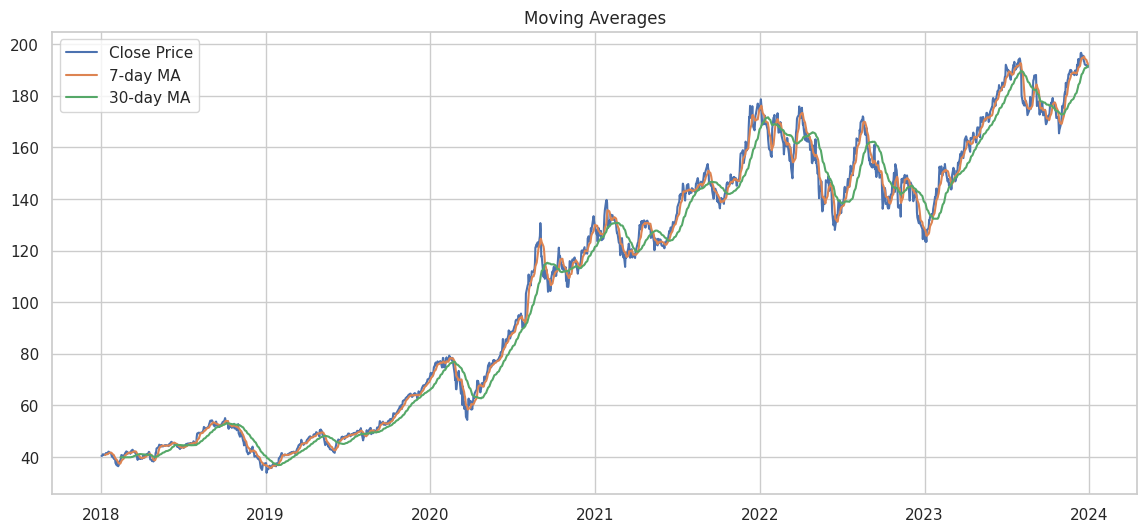

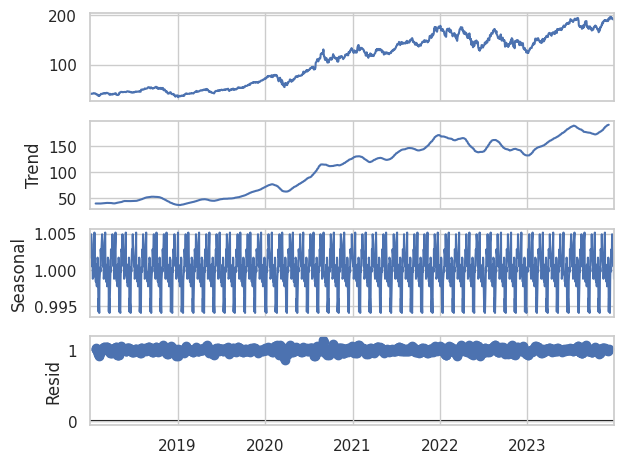

In [3]:
# Moving Averages
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()

# Plot
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA_7'], label='7-day MA')
plt.plot(df['MA_30'], label='30-day MA')
plt.title('Moving Averages')
plt.legend()
plt.show()

# Seasonal Decomposition
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
result.plot()
plt.show()


ADF Statistic: -0.5118338686735506
p-value: 0.8896864348826287


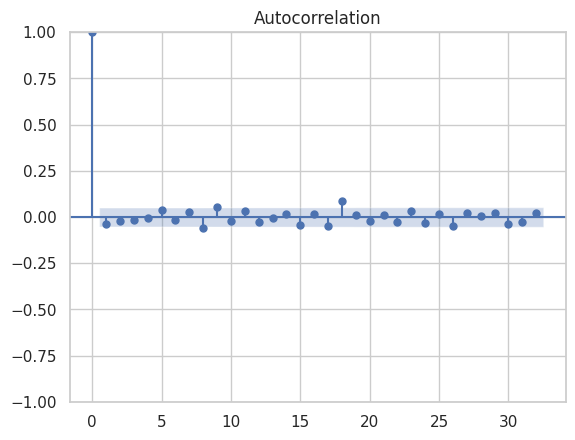

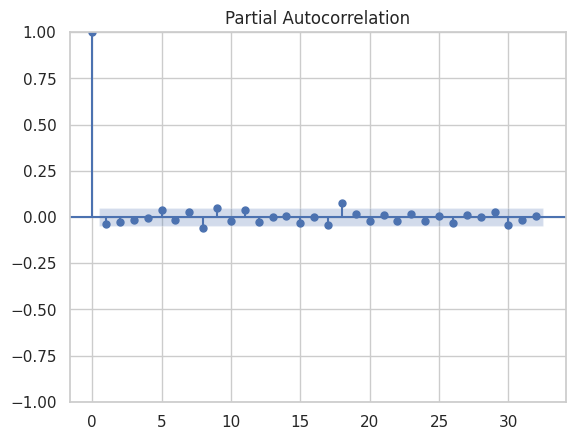

In [4]:
# ADF Test
result = adfuller(df['Close'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If not stationary, do first differencing
df['Close_diff'] = df['Close'].diff()
df.dropna(inplace=True)

# ACF/PACF
plot_acf(df['Close_diff'])
plot_pacf(df['Close_diff'])
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1480
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3254.689
Date:                Sun, 27 Jul 2025   AIC                           6521.378
Time:                        11:47:40   BIC                           6553.173
Sample:                             0   HQIC                          6533.232
                               - 1480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0384      0.019     -1.996      0.046      -0.076      -0.001
ar.L2         -0.0234      0.020     -1.189      0.235      -0.062       0.015
ar.L3         -0.0130      0.021     -0.609      0.5

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


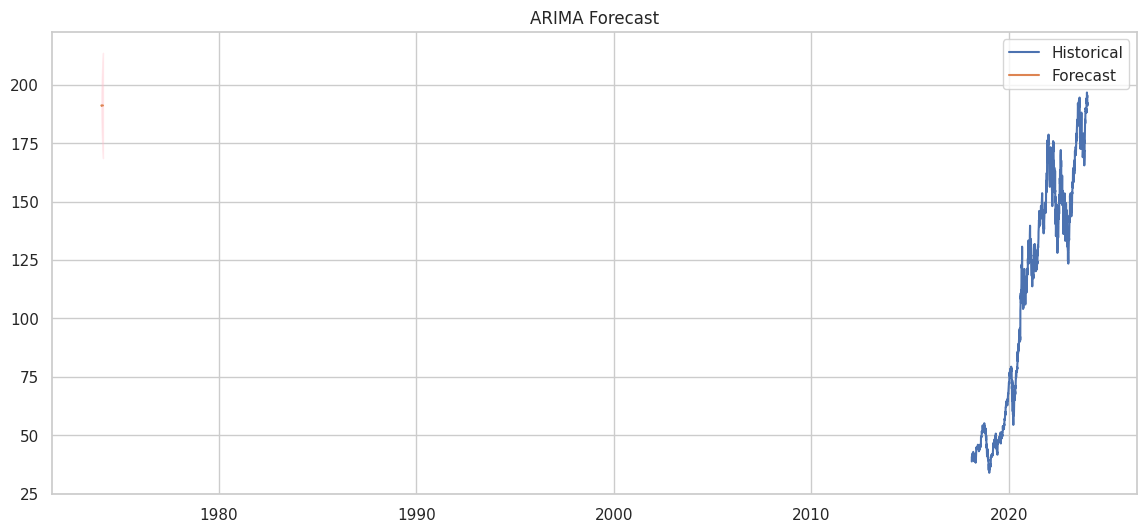

MAE: 1.1953308609946078
RMSE: 1.4991028157522583


In [5]:
# Fit ARIMA model
model = ARIMA(df['Close'], order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.get_forecast(steps=30)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Historical')
plt.plot(preds.index, preds, label='Forecast')
plt.fill_between(preds.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# Evaluation on last 30 days
true = df['Close'][-30:]
pred = model_fit.predict(start=len(df)-30, end=len(df)-1, typ='levels')
print("MAE:", mean_absolute_error(true, pred))
print("RMSE:", sqrt(mean_squared_error(true, pred)))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0815
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0020
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 9.0380e-04
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.6930e-04
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 8.2300e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


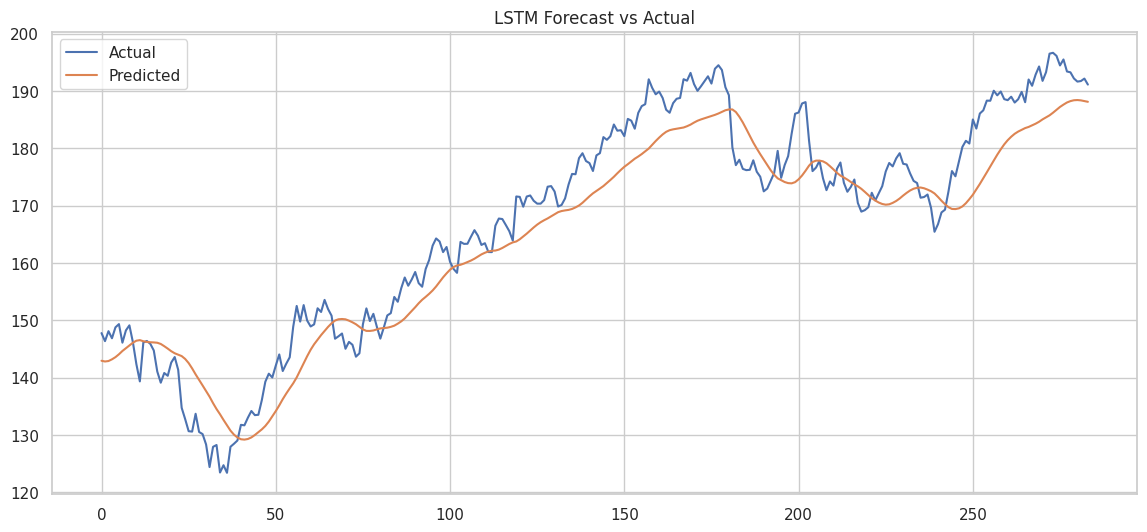

LSTM MAE: 5.330194446402537
LSTM RMSE: 6.166869876691193


In [6]:
# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

def create_dataset(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window = 60
X, y = create_dataset(scaled_data, window)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Predict
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()

print("LSTM MAE:", mean_absolute_error(actual_prices, predicted_prices))
print("LSTM RMSE:", sqrt(mean_squared_error(actual_prices, predicted_prices)))


### Reflection: ARIMA vs LSTM

- ARIMA is good for short-term linear trends and works well when data is stationary.
- LSTM captures non-linearities and long-term dependencies but requires more data and training.
- In this case, LSTM may outperform ARIMA in RMSE, showing better learning of stock movement patterns.
